In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from itertools import permutations
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM

C:\Users\mikol\.virtualenvs\Time_series_project-uFpoxpVH\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [10]:
#Commodities data==============================================================
#load data from excel file downloaded from IEA

commodities = pd.read_excel('C:/Users/mikol/Desktop/szeregi_dwa/CMO-Historical-Data-Monthly.xlsx', 'Monthly Prices')
commodities = commodities[3:]
commodities.columns = commodities.iloc[0,:]
commodities = commodities.drop(commodities.index[[0,1,2]])
commodities = commodities.set_index(commodities.iloc[:,0], drop=True).drop(commodities.columns[0], axis=1)

#Convert dataframe's index to monthly time series
month_series_commodities = pd.Series(pd.date_range("1960-01-01", periods=commodities.shape[0], freq="M"))
commodities = commodities.set_index(month_series_commodities)

#Select specific commodities price
commodities_energy_metal = commodities[['Crude oil, Brent', 'Natural gas, US',
                                        'Aluminum', 'Copper']]



In [11]:
commodities_energy_metal.tail()

3,"Crude oil, Brent","Natural gas, US",Aluminum,Copper
2021-08-31,70.02,4.0486,2602.99,9370.14
2021-09-30,74.6,5.1111,2834.56,9324.71
2021-10-31,83.65,5.478,2934.39,9829.22
2021-11-30,80.77,5.0176,2636.45,9728.9
2021-12-31,74.31,3.7327,2695.53,9551.18


In [13]:
#Industrial Production data====================================================
indust_prod = pd.read_excel('C:/Users/mikol/Desktop/szeregi_dwa/INDPRO.xls')
indust_prod = indust_prod[10:]
indust_prod = indust_prod.set_index(indust_prod.iloc[:,0], drop=True).drop(indust_prod.columns[0], axis=1)
indust_prod = indust_prod.rename(columns={'Unnamed: 1': 'US Industrial Production Index'})

#Convert dataframe's index to month time series
month_series_ip = pd.Series(pd.date_range("1919-01-01", periods=indust_prod.shape[0], freq="M"))
indust_prod = indust_prod.set_index(month_series_ip)


#Combine the dataset===========================================================
#Select the period beginning from 1990 January
commodities_energy_metal = commodities_energy_metal.loc['1990-1-1':]
commodities_energy_metal = commodities_energy_metal.astype(float)

indust_prod = indust_prod.loc['1990-1-1':]
indust_prod = indust_prod.astype(float)

df = pd.concat([indust_prod, commodities_energy_metal], axis=1, sort=False)
df.columns = ['Prod', 'Oil', 'N.Gas', 'Alum', 'Copp']

In [14]:
indust_prod.head()

,US Industrial Production Index
1990-01-31,61.9021
1990-02-28,62.4640
1990-03-31,62.7645
1990-04-30,62.6499
1990-05-31,62.8126


In [15]:
df.tail()

,Prod,Oil,N.Gas,Alum,Copp
2021-08-31,101.0025,70.02,4.0486,2602.99,9370.14
2021-09-30,100.0168,74.60,5.1111,2834.56,9324.71
2021-10-31,101.2503,83.65,5.4780,2934.39,9829.22
2021-11-30,101.9970,80.77,5.0176,2636.45,9728.90
2021-12-31,101.8926,74.31,3.7327,2695.53,9551.18


<AxesSubplot:>

<Figure size 2880x2304 with 0 Axes>

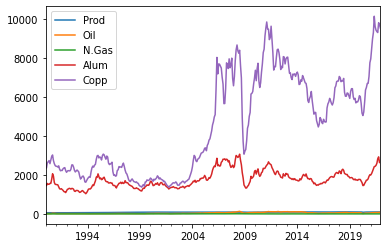

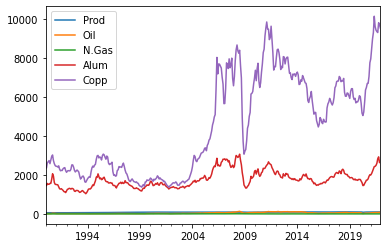

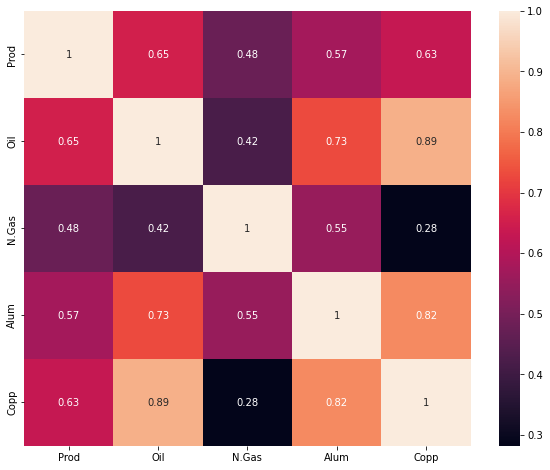

In [30]:
#plot the data and correlation matrix==========================================
plt.figure(figsize=(40,32))
df.plot()
df[['Prod', 'Oil', 'N.Gas', 'Alum', 'Copp']].plot()

plt.figure(figsize=(10,8))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)

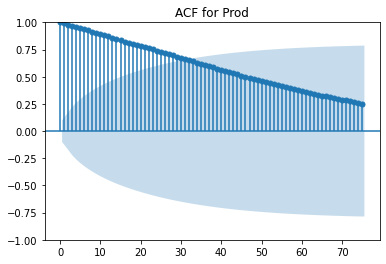

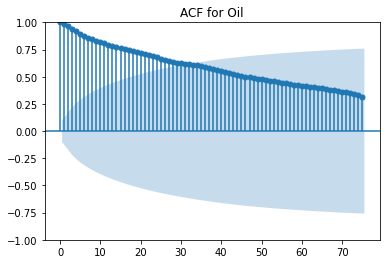

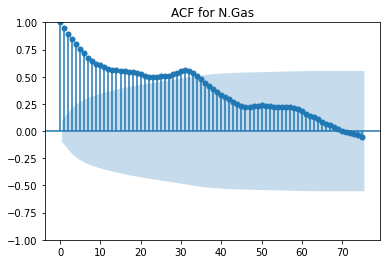

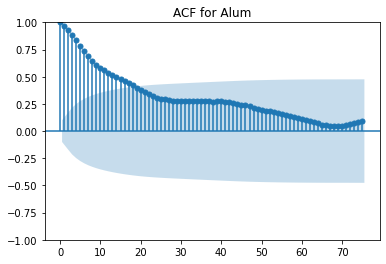

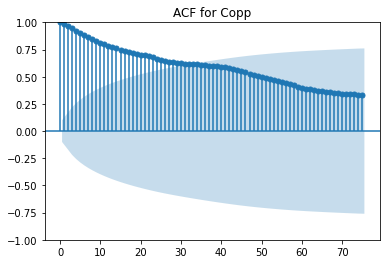

In [18]:
#Test for stationary===========================================================
# plots the autocorrelation plots for each commodties price at 75 lags
for i in df:
    plot_acf(df[i], lags = 75)
    pyplot.title('ACF for %s' % i) 
    pyplot.show()

#construct time series with first difference
df_diff = df.diff().dropna()

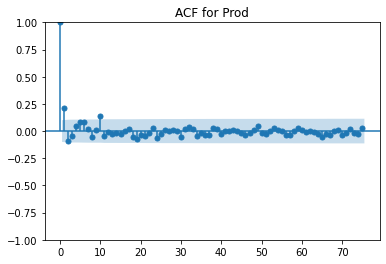

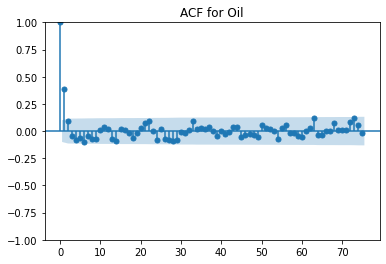

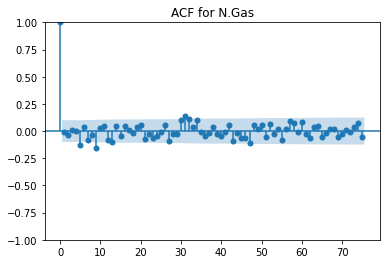

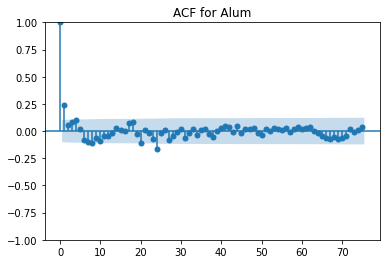

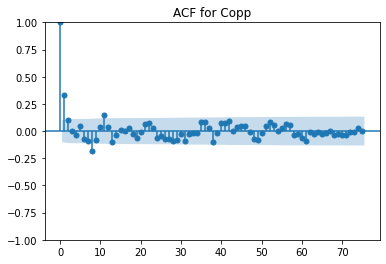

In [19]:
# plots the autocorrelation plots for the difference in each commodities price from the
# price the previous month at 75 lags
for i in df_diff:
    plot_acf(df_diff[i], lags = 75)
    pyplot.title('ACF for %s' % i) 
    pyplot.show()

In [20]:
# performs the Augmented Dickey-Fuller Test for all our variables of interest without
# a constant, with a constant, and with a constant and linear trend
for i in df_diff:
    for j in ['nc', 'c', 'ct']:
        result = adfuller(df_diff[i], regression = j)
        print('ADF Statistic with %s for %s: %f' % (j, i, result[0]))
        print('p-value: %f' % result[1])

ADF Statistic with nc for Prod: -13.957658
p-value: 0.000000
ADF Statistic with c for Prod: -14.126380
p-value: 0.000000
ADF Statistic with ct for Prod: -14.183115
p-value: 0.000000
ADF Statistic with nc for Oil: -12.855461
p-value: 0.000000
ADF Statistic with c for Oil: -12.845489
p-value: 0.000000
ADF Statistic with ct for Oil: -12.828504
p-value: 0.000000
ADF Statistic with nc for N.Gas: -7.541290
p-value: 0.000000
ADF Statistic with c for N.Gas: -7.536029
p-value: 0.000000
ADF Statistic with ct for N.Gas: -7.549532
p-value: 0.000000
ADF Statistic with nc for Alum: -7.607398
p-value: 0.000000
ADF Statistic with c for Alum: -7.707987
p-value: 0.000000
ADF Statistic with ct for Alum: -7.733199
p-value: 0.000000
ADF Statistic with nc for Copp: -5.785300
p-value: 0.000000
ADF Statistic with c for Copp: -5.867534
p-value: 0.000000
ADF Statistic with ct for Copp: -5.900909
p-value: 0.000004


C:\Users\mikol\.virtualenvs\Time_series_project-uFpoxpVH\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
C:\Users\mikol\.virtualenvs\Time_series_project-uFpoxpVH\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
C:\Users\mikol\.virtualenvs\Time_series_project-uFpoxpVH\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
C:\Users\mikol\.virtualenvs\Time_series_project-uFpoxpVH\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
C:\Users\mikol\.virtualenvs\Time_series_project-uFpoxpVH\lib\sit

In [34]:
#Granger Causality Test===========================================================
# creates a list of tuples containing the permutations of length 2
df_perms = list(permutations(df, 2))

# loops through the list of permutations
#for i in range(len(df_perms)):
for i in range(8):
    temp_list = list(df_perms[i])
    temp_df = df[temp_list]
    print('Does a lag of ' + temp_list[1] + ' predict ' + temp_list[0])
    print(grangercausalitytests(temp_df, maxlag = 3, addconst = True, verbose = True))
    print('')
    # print(------------------------------------------------------------------)
    print('')

df_selected = df[['Prod', 'Oil', 'N.Gas', 'Alum', 'Copp']]

Does a lag of Oil predict Prod

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1820  , p=0.6699  , df_denom=380, df_num=1
ssr based chi2 test:   chi2=0.1835  , p=0.6684  , df=1
likelihood ratio test: chi2=0.1834  , p=0.6684  , df=1
parameter F test:         F=0.1820  , p=0.6699  , df_denom=380, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=18.5486 , p=0.0000  , df_denom=377, df_num=2
ssr based chi2 test:   chi2=37.5892 , p=0.0000  , df=2
likelihood ratio test: chi2=35.8528 , p=0.0000  , df=2
parameter F test:         F=18.5486 , p=0.0000  , df_denom=377, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.6351 , p=0.0000  , df_denom=374, df_num=3
ssr based chi2 test:   chi2=38.6148 , p=0.0000  , df=3
likelihood ratio test: chi2=36.7809 , p=0.0000  , df=3
parameter F test:         F=12.6351 , p=0.0000  , df_denom=374, df_num=3
{1: ({'ssr_ftest': (0.1820298895964004, 0.6698761610140159, 380

In [23]:
#Johansen Cointegration test===================================================
def johansen_trace(y, p):
        N, l = y.shape
        joh_trace = coint_johansen(y, 0, p)
        r = 0
        for i in range(l):
            if joh_trace.lr1[i] > joh_trace.cvt[i, 1]:
                r = i + 1
        joh_trace.r = r

        return joh_trace

# loops through 1 to 6 lags of months
for i in range(1, 7): 
    # tests for cointegration at i lags
    joh_trace = johansen_trace(df_selected, i)
    print('Using the Trace Test, there are', joh_trace.r, '''cointegrating vectors at 
    %s lags between the series''' % i)
    print()


Using the Trace Test, there are 1 cointegrating vectors at 
    1 lags between the series

Using the Trace Test, there are 1 cointegrating vectors at 
    2 lags between the series

Using the Trace Test, there are 1 cointegrating vectors at 
    3 lags between the series

Using the Trace Test, there are 1 cointegrating vectors at 
    4 lags between the series

Using the Trace Test, there are 0 cointegrating vectors at 
    5 lags between the series

Using the Trace Test, there are 1 cointegrating vectors at 
    6 lags between the series



In [24]:
#Vector error corretion model (VECM)===========================================
# estimates the VECM on the closing prices with 6 lags, 1 cointegrating relationship, and
# a constant within the cointegration relationship
model_vecm = VECM(endog = df_selected, k_ar_diff = 6, coint_rank = 1, deterministic = 'ci')
model_vecm_fit = model_vecm.fit()
model_vecm_fit.summary()

C:\Users\mikol\.virtualenvs\Time_series_project-uFpoxpVH\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


,coef,std err,z,P>|z|,[0.025,0.975]
L1.Prod,0.1771,0.052,3.411,0.001,0.075,0.279
L1.Oil,0.0519,0.013,3.880,0.000,0.026,0.078
L1.N.Gas,0.1018,0.078,1.297,0.195,-0.052,0.256
L1.Alum,-0.0006,0.001,-0.796,0.426,-0.002,0.001
L1.Copp,0.0003,0.000,1.228,0.219,-0.000,0.001
L2.Prod,-0.1442,0.053,-2.738,0.006,-0.247,-0.041
L2.Oil,-0.0118,0.014,-0.833,0.405,-0.040,0.016
L2.N.Gas,0.0009,0.077,0.012,0.990,-0.150,0.152
L2.Alum,0.0007,0.001,0.976,0.329,-0.001,0.002
L2.Copp,1.065e-05,0.000,0.046,0.964,-0.000,0.000


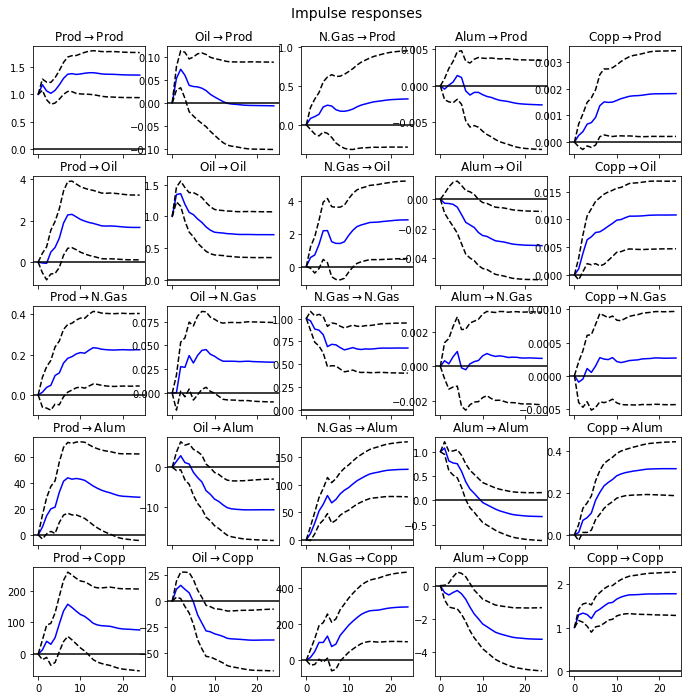

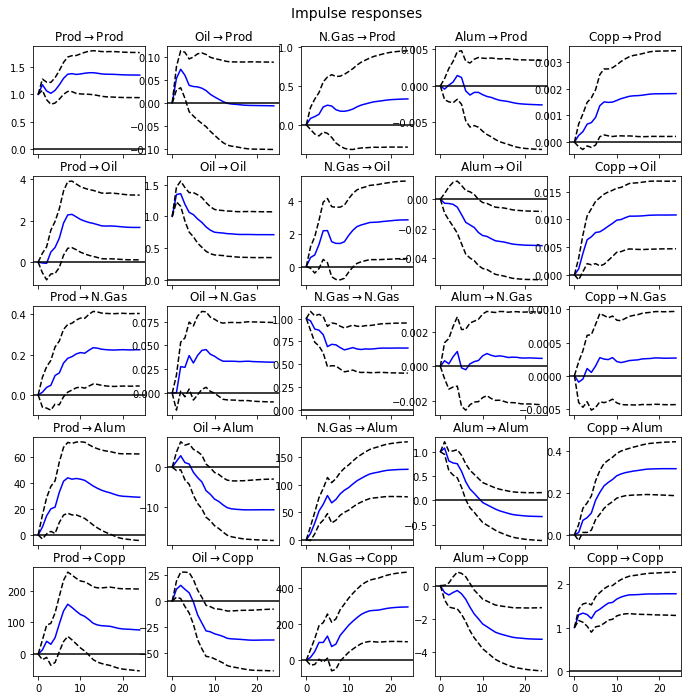

In [25]:
#Impulse response function=====================================================
irf = model_vecm_fit.irf(24)
irf.plot(orth = False)

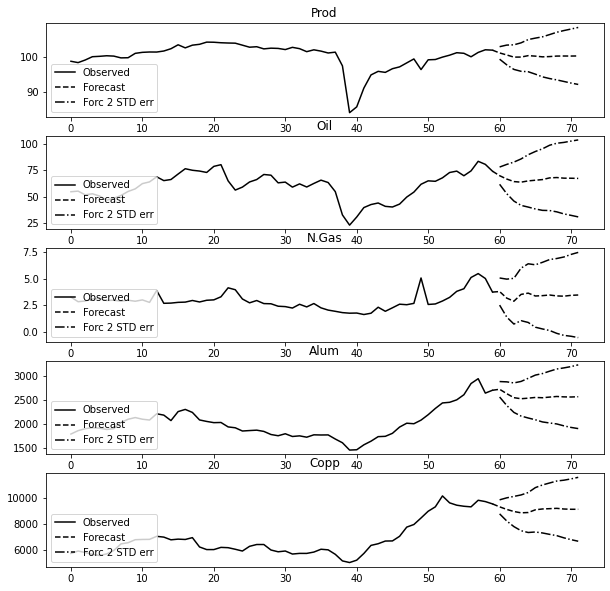

In [26]:
#Dynamic forecasting===========================================================
model_vecm_fit.plot_forecast(12, n_last_obs=60)